# 머신 러닝 교과서 - 파이토치편

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/ml-with-pytorch/blob/main/ch02/ch02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 패키지 버전 체크

check_packages.py 스크립트에서 로드하기 위해 폴더를 추가합니다:

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 python_environment_check.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
else:
    sys.path.insert(0, '..')

--2023-10-06 05:56:29--  https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1629 (1.6K) [text/plain]
Saving to: ‘python_environment_check.py’

python_environment_ 100%[===================>]   1.59K  --.-KB/s    in 0s      

2023-10-06 05:56:29 (15.9 MB/s) - ‘python_environment_check.py’ saved [1629/1629]



권장 패키지 버전을 확인하세요:

In [2]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
    'pandas': '1.3.2'
}
check_packages(d)

[OK] Your Python version is 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
[OK] numpy 1.23.5
[OK] matplotlib 3.7.1
[OK] pandas 1.5.3


# 2장 - 간단한 분류 알고리즘 훈련

### 목차


- 인공 뉴런: 초기 머신 러닝의 간단한 역사
    - 인공 뉴런의 수학적 정의
    - 퍼셉트론 학습 규칙
- 파이썬으로 퍼셉트론 학습 알고리즘 구현
    - 객체 지향 퍼셉트론 API
    - 붓꽃 데이터셋에서 퍼셉트론 훈련
- 적응형 선형 뉴런과 학습의 수렴
    - 경사 하강법으로 비용 함수 최소화
    - 파이썬으로 아달린 구현
    - 특성 스케일을 조정하여 경사 하강법 결과 향상
    - 대규모 머신 러닝과 확률적 경사 하강법
- 요약

In [3]:
from IPython.display import Image

# 인공 뉴런: 초기 머신 러닝의 간단한 역사


In [4]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch02/figures/02_01.png', width=500)

## 인공 뉴런의 수학적 정의


In [5]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch02/figures/02_02.png', width=500)

## 퍼셉트론 학습 규칙


In [6]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch02/figures/02_03.png', width=600)

In [7]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch02/figures/02_04.png', width=600)

# 파이썬으로 퍼셉트론 학습 알고리즘 구현


## 객체 지향 퍼셉트론 API


In [8]:
import numpy as np


class Perceptron:
    """퍼셉트론 분류기

    매개변수
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    b_ : 스칼라
      학습된 절편 유닛
    errors_ : list
      에포크마다 누적된 분류 오류

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        매개변수
        ----------
        X : array-like, shape = [n_samples, n_features]
          n_samples개의 샘플과 n_features개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃값

        반환값
        -------
        self : object
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)

        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """입력 계산"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

In [9]:
v1 = np.array([1, 2, 3])
v2 = 0.5 * v1
np.arccos(v1.dot(v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

0.0

## 붓꽃 데이터셋에서 퍼셉트론 훈련


### 붓꽃 데이터셋 읽기

In [10]:
import os
import pandas as pd

try:
    s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
    print('From URL:', s)
    df = pd.read_csv(s,
                     header=None,
                     encoding='utf-8')

except HTTPError:
    s = 'iris.data'
    print('From local Iris path:', s)
    df = pd.read_csv(s,
                     header=None,
                     encoding='utf-8')

df.tail()

From URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


### 붓꽃 데이터 그래프 그리기

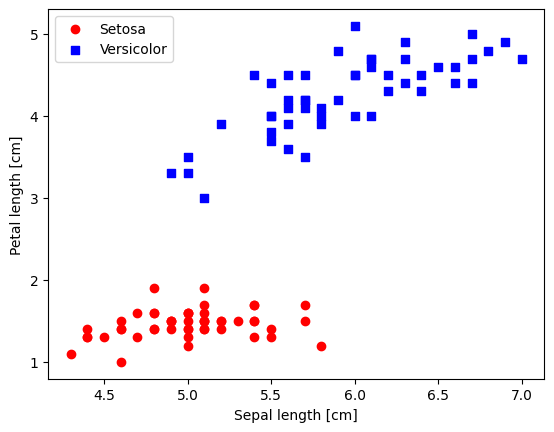

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# setosa와 versicolor를 선택합니다
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)

# 꽃받침 길이와 꽃잎 길이를 추출합니다
X = df.iloc[0:100, [0, 2]].values

# 산점도를 그립니다
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='Setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='s', label='Versicolor')

plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')

# plt.savefig('images/02_06.png', dpi=300)
plt.show()

### 퍼셉트론 모델 훈련하기

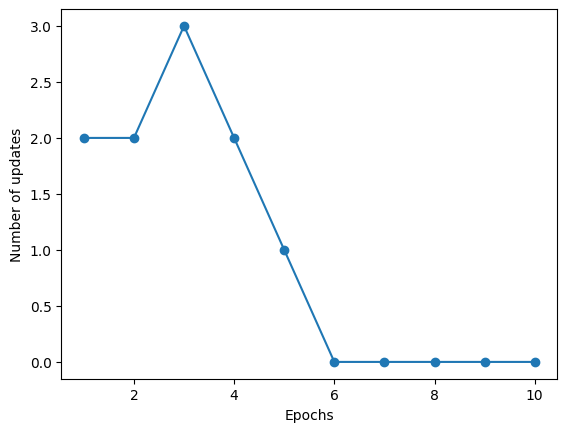

In [12]:
ppn = Perceptron(eta=0.1, n_iter=10)

ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

# plt.savefig('images/02_07.png', dpi=300)
plt.show()

### 결정 경계 그래프 함수

In [13]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # 마커와 컬러맵을 설정합니다
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 샘플의 산점도를 그립니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

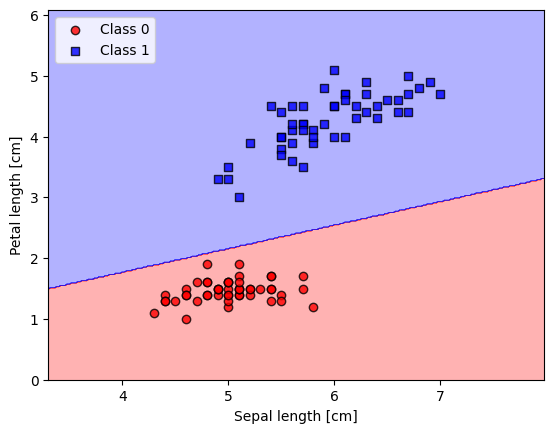

In [14]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')


#plt.savefig('images/02_08.png', dpi=300)
plt.show()

# 적응형 선형 뉴런과 학습의 수렴


## 경사 하강법으로 비용 함수 최소화


In [15]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch02/figures/02_09.png', width=600)

In [16]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch02/figures/02_10.png', width=500)

## 파이썬으로 아달린 구현


In [17]:
class AdalineGD:
    """적응형 선형 뉴런 분류기

    매개변수
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    b_ : 스칼라
      학습된 절편 유닛
    losses_ : list
      각 에포크의 평균 제곱 오차 손실 함수 값

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        매개변수
        ----------
        X : array-like, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃값

        반환값
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # 이 코드의 활성화 함수는 항등 함수(identity function)이기 때문에
            # 아무런 효과가 없습니다.
            # 이 대신 `output = self.net_input(X)`로 바로 쓸 수 있습니다.
            # 이 활성화 함수는 개념적인 목적을 위해 만들었습니다.
            # (잠시 후에 보게 될) 로지스틱 회귀의 경우 이 함수를 시그모이드 함수로
            # 바꾸어 로지스틱 회귀 분류기를 구현합니다.
            output = self.activation(net_input)
            errors = (y - output)

            #for w_j in range(self.w_.shape[0]):
            #    self.w_[w_j] += self.eta * (2.0 * (X[:, w_j]*errors)).mean()

            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """선형 활성화 계산"""
        return X

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

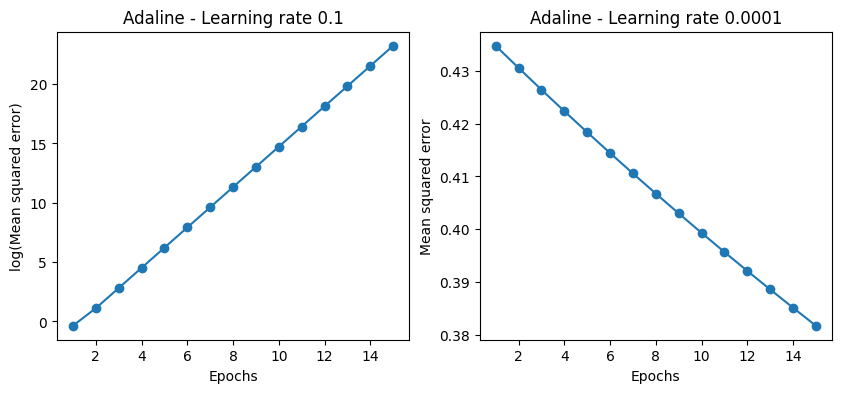

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=15, eta=0.1).fit(X, y)
ax[0].plot(range(1, len(ada1.losses_) + 1), np.log10(ada1.losses_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Mean squared error)')
ax[0].set_title('Adaline - Learning rate 0.1')

ada2 = AdalineGD(n_iter=15, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_title('Adaline - Learning rate 0.0001')

# plt.savefig('images/02_11.png', dpi=300)
plt.show()

In [19]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch02/figures/02_12.png', width=700)

## 특성 스케일을 조정하여 경사 하강법 결과 향상


In [20]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch02/figures/02_13.png', width=700)

In [21]:
# 특성을 표준화합니다.
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

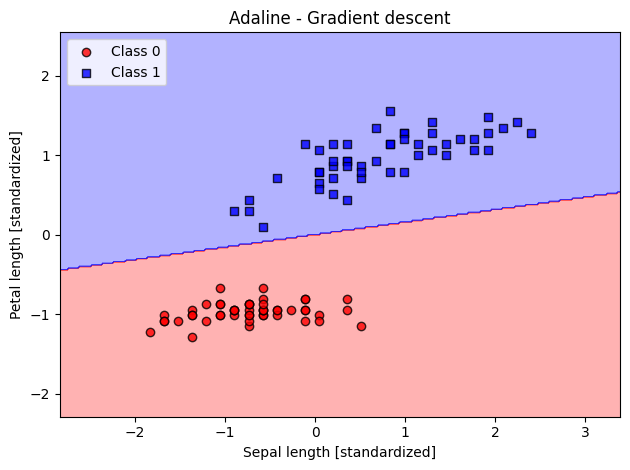

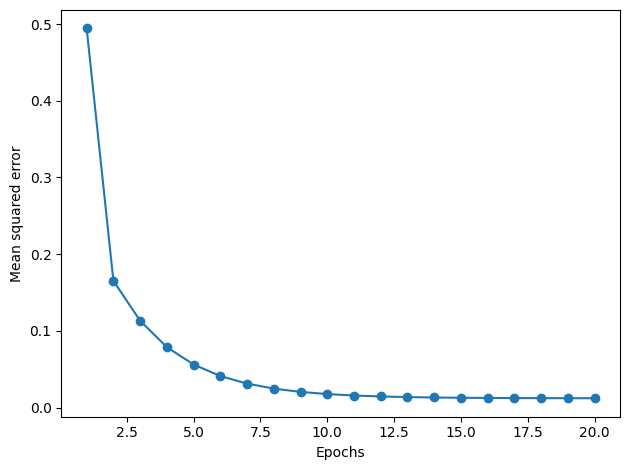

In [22]:
ada_gd = AdalineGD(n_iter=20, eta=0.5)
ada_gd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_gd)
plt.title('Adaline - Gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/02_14_1.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada_gd.losses_) + 1), ada_gd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')

plt.tight_layout()
#plt.savefig('images/02_14_2.png', dpi=300)
plt.show()

## 대규모 머신 러닝과 확률적 경사 하강법

In [23]:
class AdalineSGD:
    """ADAptive LInear NEuron 분류기

    Parameters
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    shuffle : bool (default: True)
      True로 설정하면 같은 반복이 되지 않도록 에포크마다 훈련 데이터를 섞습니다
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    Attributes
    -----------
    w_ : 1d-array
      학습된 가중치
    b_ : 스칼라
      학습된 절편 유닛
    losses_ : list
        각 에포크마다 모든 훈련 샘플에 대해 평균한 평균 제곱 오차 손실 함수 값

    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃 벡터

        반환값
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """가중치를 다시 초기화하지 않고 훈련 데이터를 학습합니다"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """훈련 데이터를 섞습니다"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """랜덤한 작은 수로 가중치를 초기화합니다"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float_(0.)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        """아달린 학습 규칙을 적용하여 가중치를 업데이트합니다"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss

    def net_input(self, X):
        """입력 계산"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """선형 활성화 계산"""
        return X

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

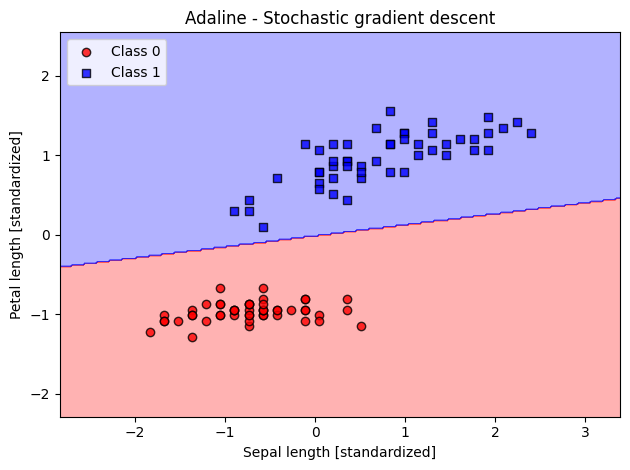

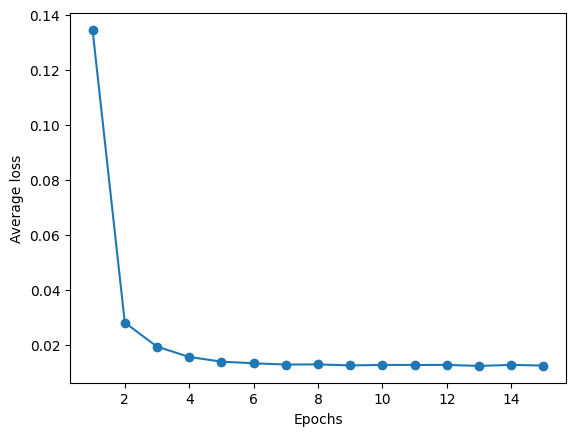

In [25]:
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/02_15_1.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada_sgd.losses_) + 1), ada_sgd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average loss')

#plt.savefig('figures/02_15_2.png', dpi=300)
plt.show()

In [26]:
ada_sgd.partial_fit(X_std[0, :], y[0])

# 요약